# Using Amazon Personalize with datasets of Infrequent Interactions


### Dataset size requirements
Amazon Personalize requires the developer to provide at least an interactions dataset (timestamp, user_id, item_id), of sufficient size. The *minimum* dataset size in order to use Amazon Personalize, follows the 1000/25/2 rule:
- At least 1000 interactions
- At least 25 users (with minimum 2 interctions each)

However, in order to expect a better performance, a larger dataset is *suggested*:
- More than 1500 interactions
- More than 50 users (with at least 10-20 interactions each)
- More than 50 items

For more details on the data requirements, please check the [Amazon Personalize Cheat-Sheet](https://github.com/aws-samples/amazon-personalize-samples/blob/master/PersonalizeCheatSheet2.0.md).

### Problem formulation: Infrequent Interactions
Unfortunately, in some cases, it is impossible to meet the suggested dataset profile. This may be true when, no real-time data is collected and simply, there is not enough historical data (e.g. only purchase interactions are collected, but not other types of interactions like clicks, likes etc.), or the **nature of the user interaction is infrequent (e.g. purchasing a car, a house, insurance etc.)**. In these cases, you may end up with 1-2 interactions per user, which barely meets the minimum dataset requirements of Amazon Personalize. 

Moreover, the [HRNN algorithm](https://arxiv.org/pdf/1706.04148.pdf), in which the User-Personalization recipe is based, works better with **session-based interactions**, e.g. a user logs in and interacts/browses/clicks/buys X items, logs out, then another time comes back again and interacts/browses/clicks/buys Y items, and so on. This interaction pattern is *very different* compared to items which are infrequently purchased, e.g. a user logs in, purchases one single item, logs out, then after a long time (if at all) logs back again and purchases another single item etc. In such cases, using the User-Personalization recipe may not give the best results, since the HRNN algorithm is not designed for this type of infrequent interactions, which are not session-based. 

### What this notebook is about

This notebook shows how to use Amazon Personalize with datasets of infrequent interactions. It particularly shows how to use a combination of **SIMS+Personalize Ranking recipes**, in order to recommend new items to users, which can give better results for infrequent interactions. 

More specifically, the notebooks includes the following sections:
1. Generating a synthetic infrequent interactions dataset
2. Setting up Amazon Personalize
3. Training 4 solutions (User Personalization, Personalized Ranking, SIMS, Popular Items) and deploying 4 campaigns. 
4. Creating a **function that combines SIMS + Personalized Ranking recipes**, in order to recommend items to users.
5. Comparing and evaluating SIMS + Personalized Ranking vs the User Personalization recipe.
6. Cleaning up resources. 

### IAM settings to run this notebook
In order to run this notebook, you need to create an IAM role that includes the following policies:
- IAMFullAccess
- AmazonS3FullAccess 
- AmazonPersonalizeFullAccess 
- AmazonSageMakerFullAccess 


### Getting started
Let's load some useful libraries.

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import time
from IPython.display import display, clear_output


## Generating a synthetic infrequent interactions dataset
In this section we will generate a synthetic infrequent interactions dataset, by sampling a gamma probability distribution. Additionally, we will identify a number of items which may be more popular than others, attracting more interactions that the rest. This function is probabilistic, and will give different results each time you run it, unless you fix the random seed. In the following case, we set the random seed to 0, to ensure reproducibility. You can set it to ```None``` to add randomness back. 


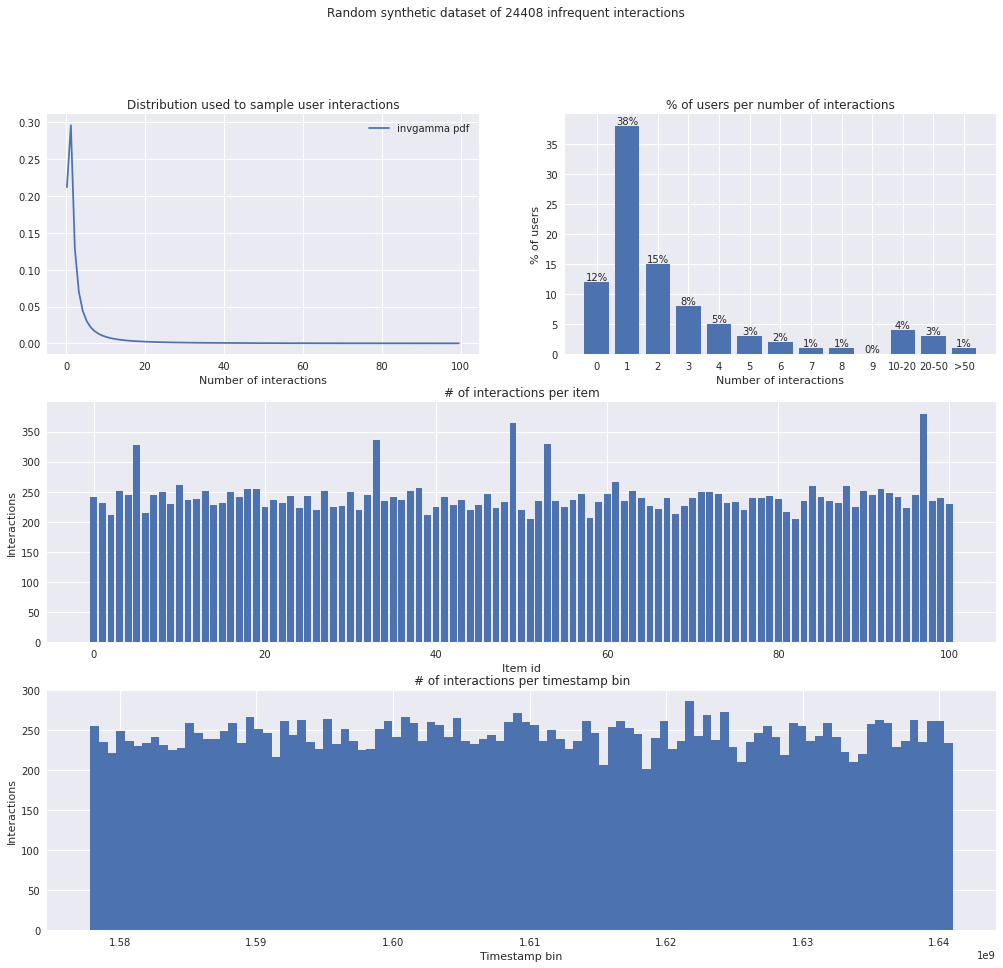

Number of unique items:  100
Number of unique users:  2000
Number of interactions:  24408
Timestamp range start: 1577836800
Timestamp range end: 1640995200
50 % of users have less than 2 interactions!
Most popular items: [49, 97, 53, 5, 33]
By a multiplication factor of: [1.5488135  1.71518937 1.60276338 1.54488318 1.4236548 ]


In [2]:
from utils.dataset_generator import generate_ii_dataset

df_dataset, df_item_popularity  = generate_ii_dataset(
    number_of_users = 2000,         # total number of users (user_id is an integer in the interval [0,number_of_users])
    number_of_items = 100,          # total number of products to interact with (item_id is an integer in the interval [0,number_of_items])
    date_begin = (2020,1,1,0,0,0),  # oldest possible timestamp (YYYY,DD,MM,HH,MM,SS)
    date_end = (2022,1,1,0,0,0),    # most recent possible timestamp (YYYY,DD,MM,HH,MM,SS)
    number_of_popular_items = 5,    # number of items which will be more popular
    max_popularity_factor = 2.0,    # up to how many times each popular item will be more popular compared to the regular ones [1,max_popularity_factor]
    random_seed = 0,                # in order to have reproducible results
    verbose = True
    )


In [3]:
# info about the generated dataframe
df_dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24408 entries, 0 to 24407
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TIMESTAMP  24408 non-null  int64 
 1   USER_ID    24408 non-null  object
 2   ITEM_ID    24408 non-null  object
dtypes: int64(1), object(2)
memory usage: 572.2+ KB


In [4]:
# display the top part of the dataset
df_dataset.head(20)


,TIMESTAMP,USER_ID,ITEM_ID
0,1578211364,user_000,item_097
1,1580669783,user_000,item_049
2,1623096152,user_001,item_093
3,1608035980,user_001,item_084
4,1614092858,user_001,item_097
5,1616126913,user_001,item_036
6,1622826726,user_001,item_090
7,1634830679,user_001,item_022
8,1626057134,user_001,item_013
9,1601650520,user_001,item_013


In [5]:
df_item_popularity.head(20)

,Interactions
ITEM_ID,
item_097,380
item_049,365
item_033,336
item_053,330
item_005,328
item_061,267
item_010,262
item_088,260
item_084,259


Save the generated dataset as a CSV file.

In [6]:
df_dataset.to_csv('infrequent_interactions.csv', index=False)  # save the dataset to a csv file


## Setting up Amazon Personalize
Let's now set up Amazon personalize, by creating a dataset group, a dataset, and uploading the csv file to S3.

In [7]:
import boto3
import json

personalize = boto3.client('personalize')


In [8]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "infrequent-interactions"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:ap-southeast-1:482414474587:dataset-group/infrequent-interactions",
  "ResponseMetadata": {
    "RequestId": "8cc9bdcb-89ca-4d7b-9730-a3f68fd303d7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:05:09 GMT",
      "x-amzn-requestid": "8cc9bdcb-89ca-4d7b-9730-a3f68fd303d7",
      "content-length": "107",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [9]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)


DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


Before we create the dataset, we need first to create a schema.

In [10]:
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "schema-personalize-infrequent-interactions",
    schema = json.dumps(interactions_schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-southeast-1:482414474587:schema/schema-personalize-infrequent-interactions",
  "ResponseMetadata": {
    "RequestId": "bc82b222-1872-48ee-b9d4-b40b2b661431",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:06:23 GMT",
      "x-amzn-requestid": "bc82b222-1872-48ee-b9d4-b40b2b661431",
      "content-length": "113",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [11]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "dataset-infrequent-interactions",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))


{
  "datasetArn": "arn:aws:personalize:ap-southeast-1:482414474587:dataset/infrequent-interactions/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "3d1ac56d-9620-4dae-886d-d34b7eaffe17",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:06:25 GMT",
      "x-amzn-requestid": "3d1ac56d-9620-4dae-886d-d34b7eaffe17",
      "content-length": "109",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [12]:
# find the region which is currently used

with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

ap-southeast-1


Let's create a new bucket, in which we will upload the dataset. 

In [13]:
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalize-infrequent"
print(bucket_name)

# if bucket does not already exist, then create it
existing_buckets = s3.list_buckets()
existing_bucket_names = [bucket['Name'] for bucket in existing_buckets['Buckets']]
if bucket_name in existing_bucket_names:
    print('Bucket', bucket_name, 'already exsits...')
else:
    print('Creating bucket', bucket_name)
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
        )


482414474587-ap-southeast-1-personalize-infrequent
Bucket 482414474587-ap-southeast-1-personalize-infrequent already exsits...


In [14]:
# upload dataset to S3
interactions_filename = 'infrequent_interactions.csv'
interactions_file_path = 'infrequent_interactions.csv'
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename


Set up the permissions for the bucket we created.

In [15]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))


{'ResponseMetadata': {'RequestId': '07SFJMTB2YHD144A',
  'HostId': 'y1U5j4YfH/RqZPJuUC4Ke+KEd2DQhk+oz8hx/DeR2qW0VJ2E4nxhIDlFO+T27ty4mQJI2xr0Pag=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'y1U5j4YfH/RqZPJuUC4Ke+KEd2DQhk+oz8hx/DeR2qW0VJ2E4nxhIDlFO+T27ty4mQJI2xr0Pag=',
   'x-amz-request-id': '07SFJMTB2YHD144A',
   'date': 'Fri, 17 Dec 2021 03:06:37 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [16]:
iam = boto3.client("iam")

role_name = "PersonalizeRole-infrequent-interactions"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::482414474587:role/PersonalizeRole-infrequent-interactions-16


Initiate a dataset import job (S3 -> Amazon Personalize). This may take a few minutes.

In [17]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "import-personalize-infrequent",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))


{
  "datasetImportJobArn": "arn:aws:personalize:ap-southeast-1:482414474587:dataset-import-job/import-personalize-infrequent",
  "ResponseMetadata": {
    "RequestId": "afe0ffb7-800f-4c8f-9265-860d998c1e81",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:08:25 GMT",
      "x-amzn-requestid": "afe0ffb7-800f-4c8f-9265-860d998c1e81",
      "content-length": "122",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


While waiting for the dataset import job to finish, we can poll the job to be notified when it finishes.

In [18]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)


DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE
CPU times: user 28.7 ms, sys: 886 µs, total: 29.6 ms
Wall time: 4min


## Training 4 solution recipes
We will now train 4 different personalization recipes. Let's see which recipes are available. 

In [19]:
personalize.list_recipes()


{'recipes': [{'name': 'aws-ecomm-customers-who-viewed-x-also-viewed',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 11, 23, 15, 10, 33, 309000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-frequently-bought-together',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-frequently-bought-together',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 11, 23, 15, 10, 33, 309000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-popular-items-by-purchases',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-purchases',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpd

In [20]:
# initiate user personalization training

user_personalization_recipe_arn = "arn:aws:personalize:::recipe/aws-user-personalization"

user_personalization_create_solution_response = personalize.create_solution(
    name = "recipe-infrequent-userpersonalization",
    datasetGroupArn = dataset_group_arn,
    recipeArn = user_personalization_recipe_arn
)

user_personalization_solution_arn = user_personalization_create_solution_response['solutionArn']
print(json.dumps(user_personalization_solution_arn, indent=2))

userpersonalization_create_solution_version_response = personalize.create_solution_version(
    solutionArn = user_personalization_solution_arn
)
userpersonalization_solution_version_arn = userpersonalization_create_solution_version_response['solutionVersionArn']
print(json.dumps(userpersonalization_create_solution_version_response, indent=2))


"arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-userpersonalization"
{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-userpersonalization/ec68d845",
  "ResponseMetadata": {
    "RequestId": "cfaba265-9d9a-4077-8149-6532307c6928",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:49 GMT",
      "x-amzn-requestid": "cfaba265-9d9a-4077-8149-6532307c6928",
      "content-length": "128",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [21]:
# initiate popular items training

popularitems_recipe_arn = "arn:aws:personalize:::recipe/aws-popularity-count"

popularitems_create_solution_response = personalize.create_solution(
    name = "recipe-infrequent-popularitems",
    datasetGroupArn = dataset_group_arn,
    recipeArn = popularitems_recipe_arn
)

popularitems_solution_arn = popularitems_create_solution_response['solutionArn']
print(json.dumps(popularitems_solution_arn, indent=2))

popularitems_create_solution_version_response = personalize.create_solution_version(
    solutionArn = popularitems_solution_arn
)
popularitems_solution_version_arn = popularitems_create_solution_version_response['solutionVersionArn']
print(json.dumps(popularitems_create_solution_version_response, indent=2))

"arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-popularitems"
{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-popularitems/42af0e35",
  "ResponseMetadata": {
    "RequestId": "09dfd204-1675-4b6f-9d84-4d4a7398e5bd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:51 GMT",
      "x-amzn-requestid": "09dfd204-1675-4b6f-9d84-4d4a7398e5bd",
      "content-length": "121",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [22]:
# initiate SIMS training

SIMS_recipe_arn = "arn:aws:personalize:::recipe/aws-sims"

sims_create_solution_response = personalize.create_solution(
    name = "recipe-infrequent-sims",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn
)

sims_solution_arn = sims_create_solution_response['solutionArn']
print(json.dumps(sims_create_solution_response, indent=2))

sims_create_solution_version_response = personalize.create_solution_version(
    solutionArn = sims_solution_arn
)

sims_solution_version_arn = sims_create_solution_version_response['solutionVersionArn']
print(json.dumps(sims_create_solution_version_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-sims",
  "ResponseMetadata": {
    "RequestId": "bdd7d4a1-6ca7-4510-bae2-acc687d6063f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:54 GMT",
      "x-amzn-requestid": "bdd7d4a1-6ca7-4510-bae2-acc687d6063f",
      "content-length": "97",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-sims/19b5d48b",
  "ResponseMetadata": {
    "RequestId": "80e81792-e70d-4164-b37f-b0c5aa373b97",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:54 GMT",
      "x-amzn-requestid": "80e81792-e70d-4164-b37f-b0c5aa373b97",
      "content-length": "113",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0

In [23]:
# initiate personalized ranking training

rerank_recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

rerank_create_solution_response = personalize.create_solution(
    name = "recipe-infrequent-rerank",
    datasetGroupArn = dataset_group_arn,
    recipeArn = rerank_recipe_arn
)

rerank_solution_arn = rerank_create_solution_response['solutionArn']
print(json.dumps(rerank_create_solution_response, indent=2))

rerank_create_solution_version_response = personalize.create_solution_version(
    solutionArn = rerank_solution_arn
)

rerank_solution_version_arn = rerank_create_solution_version_response['solutionVersionArn']
print(json.dumps(rerank_create_solution_version_response, indent=2))


{
  "solutionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-rerank",
  "ResponseMetadata": {
    "RequestId": "f42f9906-1928-4686-a5ba-6726174b9cb4",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:56 GMT",
      "x-amzn-requestid": "f42f9906-1928-4686-a5ba-6726174b9cb4",
      "content-length": "99",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-rerank/2ba8855a",
  "ResponseMetadata": {
    "RequestId": "746a2c56-ad51-48b0-aca7-429758f886bd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:14:55 GMT",
      "x-amzn-requestid": "746a2c56-ad51-48b0-aca7-429758f886bd",
      "content-length": "115",
      "connection": "keep-alive"
    },
    "RetryAttempts

Training these 4 recipes may take ~30 minutes. The following code polls (every 60 sec) the training jobs and notifies us when all recipes are ready.

In [24]:
# wait until all solutions are trained

in_progress_solution_versions = [
    userpersonalization_solution_version_arn,
    sims_solution_version_arn,
    rerank_solution_version_arn,
    popularitems_solution_version_arn
]

max_time = time.time() + 10*60*60 # 10 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
Build succeeded for arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-sims/19b5d48b
Build succeeded for arn:aws:personalize:ap-southeast-1:482

## Solution metrics
Let's just take a look at the metrics of each recipe.

In [25]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = popularitems_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-popularitems/42af0e35",
  "metrics": {
    "coverage": 0.2451,
    "mean_reciprocal_rank_at_25": 0.0709,
    "normalized_discounted_cumulative_gain_at_10": 0.1013,
    "normalized_discounted_cumulative_gain_at_25": 0.1479,
    "normalized_discounted_cumulative_gain_at_5": 0.0692,
    "precision_at_10": 0.0236,
    "precision_at_25": 0.0225,
    "precision_at_5": 0.0225
  },
  "ResponseMetadata": {
    "RequestId": "f6b36f12-0a2a-4a58-85a8-c301bec81fdc",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:38:20 GMT",
      "x-amzn-requestid": "f6b36f12-0a2a-4a58-85a8-c301bec81fdc",
      "content-length": "419",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [26]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = userpersonalization_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-userpersonalization/ec68d845",
  "metrics": {
    "coverage": 0.7941,
    "mean_reciprocal_rank_at_25": 0.0696,
    "normalized_discounted_cumulative_gain_at_10": 0.0996,
    "normalized_discounted_cumulative_gain_at_25": 0.1439,
    "normalized_discounted_cumulative_gain_at_5": 0.0632,
    "precision_at_10": 0.0255,
    "precision_at_25": 0.0183,
    "precision_at_5": 0.0255
  },
  "ResponseMetadata": {
    "RequestId": "91ec5956-4dae-416a-a673-6be585765e7a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:38:25 GMT",
      "x-amzn-requestid": "91ec5956-4dae-416a-a673-6be585765e7a",
      "content-length": "426",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [27]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = rerank_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-rerank/2ba8855a",
  "metrics": {
    "coverage": 0.6863,
    "mean_reciprocal_rank_at_25": 0.0877,
    "normalized_discounted_cumulative_gain_at_10": 0.1175,
    "normalized_discounted_cumulative_gain_at_25": 0.1773,
    "normalized_discounted_cumulative_gain_at_5": 0.0859,
    "precision_at_10": 0.0245,
    "precision_at_25": 0.0204,
    "precision_at_5": 0.0277
  },
  "ResponseMetadata": {
    "RequestId": "7d5d8ee9-f11a-49b6-9498-74523c3e21ee",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:07 GMT",
      "x-amzn-requestid": "7d5d8ee9-f11a-49b6-9498-74523c3e21ee",
      "content-length": "413",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [28]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = sims_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:482414474587:solution/recipe-infrequent-sims/19b5d48b",
  "metrics": {
    "coverage": 0.9608,
    "mean_reciprocal_rank_at_25": 0.0558,
    "normalized_discounted_cumulative_gain_at_10": 0.0672,
    "normalized_discounted_cumulative_gain_at_25": 0.1094,
    "normalized_discounted_cumulative_gain_at_5": 0.05,
    "precision_at_10": 0.0124,
    "precision_at_25": 0.013,
    "precision_at_5": 0.0135
  },
  "ResponseMetadata": {
    "RequestId": "61f2e7aa-b8b9-49fc-8b52-be0e910cdb40",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:09 GMT",
      "x-amzn-requestid": "61f2e7aa-b8b9-49fc-8b52-be0e910cdb40",
      "content-length": "408",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Creating 4 campaigns
Let's deploy the 4 recipes into campaigns, so we can use them for real-time recommendations. 

In [29]:
# deploy user personalization
create_campaign_response = personalize.create_campaign(
    name = "campaign-infrequent-userpersonalization",
    solutionVersionArn = userpersonalization_solution_version_arn,
    minProvisionedTPS = 1
)

userpersonalization_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-userpersonalization",
  "ResponseMetadata": {
    "RequestId": "b5dd981e-5c23-4a2d-b386-6a54dc04c67a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:47 GMT",
      "x-amzn-requestid": "b5dd981e-5c23-4a2d-b386-6a54dc04c67a",
      "content-length": "114",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [30]:
# deploy sims 
create_campaign_response = personalize.create_campaign(
    name = "campaign-infrequent-sims",
    solutionVersionArn = sims_solution_version_arn,
    minProvisionedTPS = 1
)

sims_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-sims",
  "ResponseMetadata": {
    "RequestId": "8da052f8-63f3-4504-9893-23974e22dd8b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:50 GMT",
      "x-amzn-requestid": "8da052f8-63f3-4504-9893-23974e22dd8b",
      "content-length": "99",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [31]:
# deploy personalized ranking
create_campaign_response = personalize.create_campaign(
    name = "campaign-infrequent-reranking",
    solutionVersionArn = rerank_solution_version_arn,
    minProvisionedTPS = 1
)

rerank_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-reranking",
  "ResponseMetadata": {
    "RequestId": "933dc1b0-cc99-4ba0-8f3f-46946dc9a092",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:52 GMT",
      "x-amzn-requestid": "933dc1b0-cc99-4ba0-8f3f-46946dc9a092",
      "content-length": "104",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [32]:
# deploy popular items
create_campaign_response = personalize.create_campaign(
    name = "campaign-infrequent-popularitems",
    solutionVersionArn = popularitems_solution_version_arn,
    minProvisionedTPS = 1
)

popularitems_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-popularitems",
  "ResponseMetadata": {
    "RequestId": "55d7d425-1f96-4ae4-90d0-39d51ea2a318",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 17 Dec 2021 03:53:54 GMT",
      "x-amzn-requestid": "55d7d425-1f96-4ae4-90d0-39d51ea2a318",
      "content-length": "107",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Similar to the training step, the following code polls and informs us when all 4 compaigns are deployed. 

In [33]:
%%time

campaign_arns = [
    userpersonalization_campaign_arn,
    sims_campaign_arn,
    rerank_campaign_arn,
    popularitems_campaign_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in reversed(campaign_arns):
        campaign_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = campaign_response["campaign"]["status"]

        if status == "ACTIVE":
            print(f'Campaign {campaign_arn} successfully completed')
            campaign_arns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print(f'Campaign {campaign_arn} failed')
            if campaign_response.get('failureReason'):
                print('   Reason: ' + campaign_response['failureReason'])
            campaign_arns.remove(campaign_arn)

    if len(campaign_arns) > 0:
        print('At least one campaign is still in progress')
        time.sleep(60)
    else:
        print("All campaigns have completed")
        break

At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
Campaign arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-popularitems successfully completed
At least one campaign is still in progress
Campaign arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-reranking successfully completed
Campaign arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-sims successfully completed
Campaign arn:aws:personalize:ap-southeast-1:482414474587:campaign/campaign-infrequent-userpersonalization successfully completed
All campaigns have completed
CPU times: user 109 ms, sys: 5.55 ms, total: 114 ms
Wall time: 8min 1s


## Testing the campaigns

In [34]:
personalize_runtime = boto3.client('personalize-runtime')


In [35]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = userpersonalization_campaign_arn,
    userId = 'user_000',
    numResults = 20
)

item_list = get_recommendations_response['itemList']
recommended_items = [item['itemId'] for item in item_list]
print('User-personalization recommendations:', recommended_items)

User-personalization recommendations: ['item_049', 'item_005', 'item_011', 'item_073', 'item_093', 'item_043', 'item_032', 'item_097', 'item_045', 'item_053', 'item_074', 'item_017', 'item_003', 'item_060', 'item_022', 'item_030', 'item_010', 'item_092', 'item_020', 'item_046']


In [36]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = popularitems_campaign_arn,
    userId = 'user_000',
    numResults = 20
)

item_list = get_recommendations_response['itemList']
recommended_items = [item['itemId'] for item in item_list]
print('Popular items recommendations:', recommended_items)

Popular items recommendations: ['item_097', 'item_049', 'item_053', 'item_005', 'item_033', 'item_010', 'item_027', 'item_037', 'item_017', 'item_073', 'item_061', 'item_032', 'item_043', 'item_090', 'item_088', 'item_011', 'item_093', 'item_060', 'item_084', 'item_083']


In [43]:
item_id = 'item_000'

get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = sims_campaign_arn,
    itemId = item_id,
    numResults = 20
)

item_list = get_recommendations_response['itemList']
similar_items = [item['itemId'] for item in item_list]
print('Similar items to', item_id, ':', similar_items)

Similar items to item_000 : ['item_063', 'item_001', 'item_094', 'item_017', 'item_031', 'item_097', 'item_067', 'item_054', 'item_019', 'item_006', 'item_015', 'item_058', 'item_055', 'item_090', 'item_056', 'item_053', 'item_089', 'item_100', 'item_086', 'item_051']


## Custom recipe for infrequent interaction data
In this section we will create a new helper function ```get_recommendations()``` that combines the **SIMS+Personalize Ranking recipes**. A description of the approach can be seen in the following image.

![example](static/example.png "example")

This approach was found to give better results for datasets of infrequent interactions, compared to the User-presonalization recipe. For this type of interactions, the User-presonalization recipe tends to give results that follow the most popular items. Instead, SIMS+Personalize Ranking was found to provide greater variation of recommendations. 

In [52]:
def get_recommendations(user_id, df_dataset, sims_campaign_arn, rerank_campaign_arn, popularitems_campaign_arn, max_items=20):
    # simple function for providing recommendations for datasets with infrequent interactions
    # based on SIMS+Personalized Ranking recipes
    
    # get all interactions of the user
    ls_user_similar_items = []
    ls_user_interactions = list(df_dataset[df_dataset['USER_ID']==user_id]['ITEM_ID'].values)
    number_of_items = min(len(df_dataset['ITEM_ID'].unique()), 499)

    # get the similar items for each of the user's interaction and add them in a list
    for interaction in ls_user_interactions:
        get_recommendations_response = personalize_runtime.get_recommendations(
            campaignArn = sims_campaign_arn,
            itemId = interaction,
            numResults = number_of_items
        )
        item_list = get_recommendations_response['itemList']
        ls_user_similar_items.extend([item['itemId'] for item in item_list])  # add similar items to the ones the user interacted with
        
    ls_user_similar_items = list(set(ls_user_similar_items))  # keep only the unique items
    ls_user_similar_items = [item for item in ls_user_similar_items if item not in ls_user_interactions]  # remove any previously interacted items
    
    if len(ls_user_similar_items) is not 0:
        # rerank the similar items for the user
        response = personalize_runtime.get_personalized_ranking(
            campaignArn=rerank_campaign_arn,
            inputList=ls_user_similar_items,
            userId=user_id
        )
        reranked = response['personalizedRanking']
        ls_recommended_items = [item['itemId'] for item in reranked]
    else:
        # since the user does not have any interactions, recommend the most popular items
        get_recommendations_response = personalize_runtime.get_recommendations(
            campaignArn = popularitems_campaign_arn,
            userId = str(user_id),
            numResults = max_items
        )
        item_list = get_recommendations_response['itemList']
        ls_recommended_items = [item['itemId'] for item in item_list]
    
    return ls_recommended_items[:max_items]
    

In [54]:
get_recommendations(
    user_id='user_000', 
    df_dataset=df_dataset, 
    sims_campaign_arn=sims_campaign_arn, 
    rerank_campaign_arn=rerank_campaign_arn, 
    popularitems_campaign_arn=popularitems_campaign_arn,
    max_items=10
)

['item_043',
 'item_042',
 'item_032',
 'item_010',
 'item_087',
 'item_088',
 'item_005',
 'item_090',
 'item_053',
 'item_084']

Lets compare side by side the recommendations from the SIMS+Reranking vs the User-Personalizetion recipes, for the first 20 users.

In [55]:
for user in range(20):  # for the first 20 users
    
    user_id = 'user_' + ('%0*d' % (3, user))
    number_of_recommendations = 10
    
    ls_user_interactions = list(df_dataset[df_dataset['USER_ID']==user_id]['ITEM_ID'].values)
    
    userpersonalization_response = personalize_runtime.get_recommendations(
        campaignArn = userpersonalization_campaign_arn,
        userId = user_id,
        numResults = number_of_recommendations
    )
    item_list = userpersonalization_response['itemList']
    userpersonalization_items = [item['itemId'] for item in item_list]
    
    
    print('User', user, '\n', 
          'Historical interacted items:', ls_user_interactions, '\n',
          'SIMS + reranking items:     ', 
          get_recommendations(
                user_id=user_id, 
                df_dataset=df_dataset, 
                sims_campaign_arn=sims_campaign_arn, 
                rerank_campaign_arn=rerank_campaign_arn, 
                popularitems_campaign_arn=popularitems_campaign_arn,
                max_items=number_of_recommendations
                ), '\n',
          'User-personalization items: ', userpersonalization_items
         )


User 0 
 Historical interacted items: ['item_097', 'item_049'] 
 SIMS + reranking items:      ['item_043', 'item_042', 'item_032', 'item_010', 'item_087', 'item_088', 'item_005', 'item_090', 'item_053', 'item_084'] 
 User-personalization items:  ['item_049', 'item_005', 'item_011', 'item_073', 'item_093', 'item_043', 'item_032', 'item_097', 'item_045', 'item_053']
User 1 
 Historical interacted items: ['item_093', 'item_084', 'item_097', 'item_036', 'item_090', 'item_022', 'item_013', 'item_013', 'item_009'] 
 SIMS + reranking items:      ['item_049', 'item_010', 'item_087', 'item_017', 'item_032', 'item_088', 'item_059', 'item_014', 'item_083', 'item_033'] 
 User-personalization items:  ['item_017', 'item_043', 'item_093', 'item_011', 'item_073', 'item_049', 'item_098', 'item_061', 'item_007', 'item_053']
User 2 
 Historical interacted items: ['item_080', 'item_099', 'item_053', 'item_071', 'item_060', 'item_014', 'item_009', 'item_007', 'item_086', 'item_033', 'item_056', 'item_035',

## Cleaning up resources
Make sure to run the following cell, in order to clean-up any Amazon Personalize resources that has been created, and avoid any unnecessary costs.

In [ ]:
from utils.delete_resources import delete_dataset_groups

delete_dataset_groups([dataset_group_arn], region)